In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler

In [2]:
class Transformer(nn.Module):
    def __init__(self,feature_size=250,num_layers=1,dropout=0.1):
        super(Transformer, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(feature_size)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=feature_size, nhead=10, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)        
        self.decoder = nn.Linear(feature_size,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.pos_encoder(src)
        output = self.transformer_encoder(src,self.src_mask)#, self.src_mask)
        output = self.decoder(output)
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()       
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [4]:
def get_batch(source, i,batch_size):
    seq_len = min(batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len]    
    input = torch.stack(torch.stack([item[0] for item in data]).chunk(input_window,1)) # 1 is feature size
    target = torch.stack(torch.stack([item[1] for item in data]).chunk(input_window,1))
    return input, target

In [5]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = np.append(input_data[i:i+tw][:-output_window] , output_window * [0])
        train_label = input_data[i:i+tw]
        #train_label = input_data[i+output_window:i+tw+output_window]
        inout_seq.append((train_seq ,train_label))
    return torch.FloatTensor(inout_seq)

In [6]:
def train(train_data):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i,batch_size)
        optimizer.zero_grad()
        output = model(data)        

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()

In [7]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for i in range(0, len(data_source) - 1, eval_batch_size):
            data, targets = get_batch(data_source, i,eval_batch_size)
            output = eval_model(data)            
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-output_window:], targets[-output_window:]).cpu().item()            
    return total_loss / len(data_source)

In [8]:
def plot_and_loss(eval_model, data_source, epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i in range(0, len(data_source) - 1):
            data, target = get_batch(data_source, i,1)
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-output_window:], target[-output_window:]).item()
            
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    
    pyplot.plot(test_result,color="red")
    pyplot.plot(truth[:len(test_result)],color="blue")
    # print("预测数据的条目数为：", len(test_result))
    # print("真实数据的条目数为：", len(truth))
    # pyplot.plot(test_result-truth,color="green") # 误差曲线
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-epoch%d.png'%epoch)
    pyplot.close()

    if epoch == 200:
        global final_data_mear
        final_data_mear = truth[:len(test_result)].tolist()
        global final_data_pred
        final_data_pred = test_result.tolist()
    return total_loss / i

In [9]:
def predict_future(eval_model, data_source,steps):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    _ , data = get_batch(data_source, 0,1)
    with torch.no_grad():
        for i in range(0, steps,1):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = eval_model(data[-input_window:])                        
            data = torch.cat((data, output[-1:]))
            
    data = data.cpu().view(-1)
    

    pyplot.plot(data,color="red")       
    pyplot.plot(data[:input_window],color="blue")
    pyplot.grid(True, which='both')
    pyplot.axhline(y=0, color='k')
    pyplot.savefig('graph/transformer-future%d.png'%steps)
    pyplot.close()

In [10]:
# 定义超参数
torch.manual_seed(0)
np.random.seed(0)
calculate_loss_over_all_values = False

feature_size = 250
num_layers = 1
dropout = 0.1
input_window = 100
output_window = 1 # 最佳参数是1
batch_size = 360
lr = 0.001
epochs = 200
best_val_loss = float("inf")
best_model = None

final_data_mear = []
final_data_pred = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# 读取数据
data_path = "datasets_raw_processed.csv"
raw_data = pd.read_csv(data_path).iloc[:,1]
scaler = MinMaxScaler(feature_range=(-1,1))
norm_data = scaler.fit_transform(raw_data.to_numpy().reshape(-1,1)).reshape(-1)

# 将数据分割为训练集和测试集
train_data = norm_data[:-210]
test_data = norm_data[-210:]

train_tensor = torch.FloatTensor(train_data).view(-1)
train_sequence = create_inout_sequences(train_data,input_window)
# train_sequence = train_sequence[:-output_window]
train_sequence = train_sequence[:-output_window].to(device)
test_data = torch.FloatTensor(test_data).view(-1)
test_data = create_inout_sequences(test_data,input_window)
# test_data = test_data[:-output_window]
test_data = test_data[:-output_window].to(device)

In [19]:
# 定义模型
model = Transformer(feature_size=feature_size, num_layers=num_layers, dropout=dropout).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

In [20]:
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(train_sequence) # 开始训练
    if(epoch % 10 == 0):
        val_loss = plot_and_loss(model, test_data,epoch)
        predict_future(model, test_data,200)
    else:
        val_loss = evaluate(model, test_data)      
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time), val_loss, math.exp(val_loss)))
    print('-' * 89)
    scheduler.step()

/root/miniconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |     5/   29 batches | lr 0.001000 | 62.40 ms | loss 22.62480 | ppl 6696187283.07
| epoch   1 |    10/   29 batches | lr 0.001000 | 20.11 ms | loss 0.99207 | ppl     2.70
| epoch   1 |    15/   29 batches | lr 0.001000 | 20.01 ms | loss 0.39624 | ppl     1.49
| epoch   1 |    20/   29 batches | lr 0.001000 | 20.26 ms | loss 0.29645 | ppl     1.35
| epoch   1 |    25/   29 batches | lr 0.001000 | 20.00 ms | loss 0.19753 | ppl     1.22
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  0.79s | valid loss 0.31995 | valid ppl     1.38
-----------------------------------------------------------------------------------------
| epoch   2 |     5/   29 batches | lr 0.000960 | 24.12 ms | loss 0.23785 | ppl     1.27
| epoch   2 |    10/   29 batches | lr 0.000960 | 19.97 ms | loss 0.12172 | ppl     1.13
| epoch   2 |    15/   29 batches | lr 0.000960 | 20.01 ms | loss 0.32090 | ppl     1.38
| epoch   2 |    20/   29 

In [24]:
# 数据反归一化
data_pred = np.array(final_data_pred).reshape(-1,1)
data_mear = np.array(final_data_mear).reshape(-1,1)
norm_data_pred = scaler.inverse_transform(data_pred).reshape(-1)
norm_data_mear = scaler.inverse_transform(data_mear).reshape(-1)

print("实测数据：", norm_data_mear.tolist()) # 定位输出位置
print(len(norm_data_mear))
print("预测数据：", norm_data_pred.tolist())

实测数据： [1.011998637065294, 4.641998815894129, 8.64050075826049, 12.792998869657518, 18.232500792846086, 22.011000921025875, 24.023998817533258, 26.229500426828864, 29.623001630932094, 39.09950028799474, 54.63150042199344, 65.27399998020753, 73.80450008164905, 81.22950020591541, 85.33250045957044, 88.89099983625114, 91.03050005114079, 90.30449959030003, 88.60499981572106, 84.84300003614277, 76.94499983705022, 70.28450001289788, 58.35500009662658, 47.45949908971041, 40.48549981527031, 37.84549929878116, 33.824999725446105, 29.876002016946675, 30.2994999832809, 27.989497937321666, 20.82850179664791, 15.251500864967706, 11.220000350773336, 7.8430005579590825, 4.977502007603648, 0.9405010229796198, 0.3960012086927917, 0.9460014934092786, 4.542998849660161, 6.754000929385426, 10.48300107444823, 15.982999670863153, 19.695498404636982, 21.493999208137396, 23.875498868182305, 28.45699966709316, 39.36899995992333, 51.65050049411506, 63.55249991794117, 71.29649999613396, 79.06800023468212, 82.8355

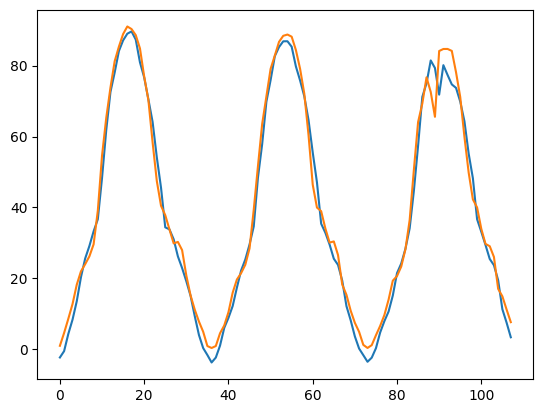

In [25]:
pyplot.plot(norm_data_pred)
pyplot.plot(norm_data_mear)
pyplot.show()

MSE: 16.81765741987031
RMSE: 4.100933725369177
PICP: 0.8240740740740741
PINAW: 10.73255998846304


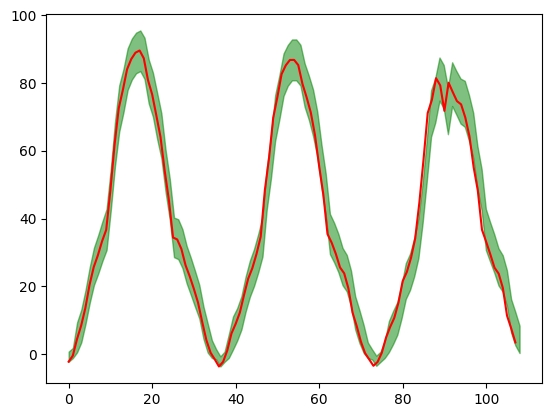

In [28]:
from KDE_cul import *

# 参数计算
def MSE(data_true, data_pred):  
    """计算MSE"""  
    return np.mean((data_true - data_pred) ** 2)
def RMSE(data_true, data_pred):  
    """计算RMSE"""
    mse = np.mean((data_true - data_pred) ** 2)
    return np.sqrt(mse)

norm_data_mear = norm_data_mear[-108:]
norm_data_pred = norm_data_pred[-108:]

# 计算MSE和RMSE
mse = MSE(data_true = norm_data_mear, data_pred = norm_data_pred)
rmse = RMSE(data_true = norm_data_mear, data_pred = norm_data_pred)
print("MSE:", mse)
print("RMSE:", rmse)

# 置信度95，计算PICP和PINAW
def PICP(data_true, lower_bound, upper_bound): 
    """ 
    计算置信区间覆盖概率
    """ 
    # 计算置信区间覆盖情况，得到布尔值数组 
    covered = (lower_bound <= data_true) & (data_true <= upper_bound) # 计算置信区间覆盖概率 
    picp = np.mean(covered) 
    return picp

def PINAW(lower_bound, upper_bound):
    """
    计算平均区间宽度（PINAW）
    """
    lower_bound = np.array([lower_bound])
    upper_bound = np.array([upper_bound])
    width = upper_bound - lower_bound
    PINAW = np.mean(width)
    return PINAW

confidence = 92
value = norm_data_pred
a_list95 = []
b_list95 = []
for i in range(0, len(value), 1):
    a,b = cul_interval(value=value[i], confi=confidence)
    a_list95.append(a)
    b_list95.append(b)
picp = PICP(data_true=norm_data_mear, lower_bound=a_list95, upper_bound=b_list95)
print("PICP:", picp)
pinaw = PINAW(lower_bound=a_list95, upper_bound=b_list95)
print("PINAW:", pinaw)
# pyplot.plot(a_list95, color="blue")
pyplot.plot(value, color="red")
# pyplot.plot(b_list95, color="blue")
num_pred = len(norm_data_pred)
x = np.linspace(start=0, stop=num_pred, num=num_pred)
pyplot.fill_between(x.tolist(), a_list95, b_list95, color='green', alpha=0.5, label='预测区间(置信度90)') 
pyplot.show()

